# Options pricing methologies and Greeks

## Options pricing

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

- I couldn't calculate volatility from the file because the data seem to be very strange. The assumption on volatility is 0.2 (20%)

In [2]:
# Read the Excel file
df_initial = pd.read_excel('/Users/slitasov/Downloads/Options_call_put.xlsx', engine='openpyxl')
strike = df_initial['Strike']

data = {
    'strike': strike
}

# Create DataFrame
df = pd.DataFrame(data).copy()

df['european_stock_call'] = np.nan
df['european_stock_put'] = np.nan
df['european_currency_call'] = np.nan
df['european_currency_put'] = np.nan


df['american_stock_call'] = np.nan
df['american_stock_put'] = np.nan
df['american_currency_call'] = np.nan
df['american_currency_put'] = np.nan

### Dividend yield calculation

In [3]:
def calculate_dividend_yield(F, S, T, r):
    
    q = r - math.log(F/S) / T
    return q


In [4]:
def calculate_foreign_yield(F, S, T, r):
    
    r_f = r - math.log(F/S) / T
    return r_f

In [5]:
# Calculate dividend yield
F = 91.1
S = 90.2
T = 70/365
r = 0.072

q = calculate_dividend_yield(F, S, T, r)
print('Dividend yield (q) - ', q)

Dividend yield (q) -  0.020230604613898813


In [6]:
# Calculate foreign risk-free rate
F = 89.3
S = 90.2
T = 70/365
r = 0.072

r_f = calculate_dividend_yield(F, S, T, r)
print('Foreign yield (r_f) - ', r_f)

Foreign yield (r_f) -  0.12428854004193562


### 1. Binomial tree model

#### European option

In [7]:
def european_binomial_option(S, K, T, r, q, sigma, option_type, steps=12):
    dt = T / steps
    discount = math.exp(-r * dt)

    # Calculate u and d
    u = math.exp(sigma * math.sqrt(dt))
    d = math.exp(-sigma * math.sqrt(dt))

    # Calculate the risk-neutral probability
    p = (math.exp((r - q) * dt) - d) / (u - d)

    def option_price(step, stock_price):
        if step == steps:
            if option_type == 'call':
                return max(stock_price - K, 0)
            elif option_type == 'put':
                return max(K - stock_price, 0)
        else:
            up_price = option_price(step + 1, stock_price * u)
            down_price = option_price(step + 1, stock_price * d)

            return discount * (p * up_price + (1-p) * down_price)

    return option_price(0, S)

In [8]:
S = 90.2  # Stock price
T = 70/365  # Time to maturity (in years)
r = 0.072  # Risk-free rate
sigma = 0.2  # Volatility (assumption!)
q = q # Dividend yield

for i in range(len(df)):
    strike = df['strike'][i]
    european_stock_call = european_binomial_option(S, strike, T, r, q, sigma, option_type ='call')
    european_stock_put = european_binomial_option(S, strike, T, r, q, sigma, option_type ='put')
    
    european_currency_call = european_binomial_option(S, strike, T, r, r_f, sigma, option_type ='call')
    european_currency_put = european_binomial_option(S, strike, T, r, r_f, sigma, option_type ='put')
    
    
    df.loc[i, "european_stock_call"] = european_stock_call
    df.loc[i, "european_stock_put"] = european_stock_put
    
    df.loc[i, "european_currency_call"] = european_currency_call
    df.loc[i, "european_currency_put"] = european_currency_put

#### American option

In [9]:
def american_binomial_option(S, K, T, r, q, sigma, option_type, steps=12):
    dt = T / steps
    discount = math.exp(-r * dt)

    # Calculate u and d
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u  # instead of math.exp(-sigma * math.sqrt(dt))

    # Calculate the risk-neutral probability
    p = (math.exp((r - q) * dt) - d) / (u - d)

    def option_price(step, stock_price):
        if step == steps:
            if option_type == 'call':
                return max(stock_price - K, 0)
            elif option_type == 'put':
                return max(K - stock_price, 0)
        else:
            up_price = option_price(step + 1, stock_price * u)
            down_price = option_price(step + 1, stock_price * d)
            if option_type == 'call':
                early_exercise = max(stock_price - K, 0)
            elif option_type == 'put':
                early_exercise = max(K - stock_price, 0)
            
            # Take the maximum value between continuing and exercising early
            return max(early_exercise, discount * (p * up_price + (1-p) * down_price))

    return option_price(0, S)


In [10]:
S = 90.2  # Stock price
T = 70/365  # Time to maturity (in years)
r = 0.072  # Risk-free rate
T = 1
sigma = 0.2  # Volatility (assumption!)
q = q # Dividend yield

for i in range(len(df)):
    strike = df['strike'][i]
    american_stock_call = american_binomial_option(S, strike, T, r, q, sigma, option_type ='call')
    american_stock_put = american_binomial_option(S, strike, T, r, q, sigma, option_type ='put')
    
    american_currency_call = american_binomial_option(S, strike, T, r, r_f, sigma, option_type ='call')
    american_currency_put = american_binomial_option(S, strike, T, r, r_f, sigma, option_type ='put')
    
    
    df.loc[i, "american_stock_call"] = american_stock_call
    df.loc[i, "american_stock_put"] = american_stock_put
    
    df.loc[i, "american_currency_call"] = american_currency_call
    df.loc[i, "american_currency_put"] = american_currency_put


#### Result analysis

In [11]:
df.head(5)

,strike,european_stock_call,european_stock_put,european_currency_call,european_currency_put,american_stock_call,american_stock_put,american_currency_call,american_currency_put
0,60.0,30.673516,0.0,28.898200,0.0,32.611939,0.051374,30.2,0.181651
1,60.5,30.180372,0.0,28.405056,0.0,32.152710,0.057444,29.7,0.201856
2,65.0,25.742082,0.0,23.966766,0.0,28.064903,0.164691,25.2,0.489619
3,65.5,25.248939,0.0,23.473623,0.0,27.624396,0.189646,24.7,0.553645
4,66.0,24.755796,0.0,22.980480,0.0,27.183889,0.214601,24.2,0.617670


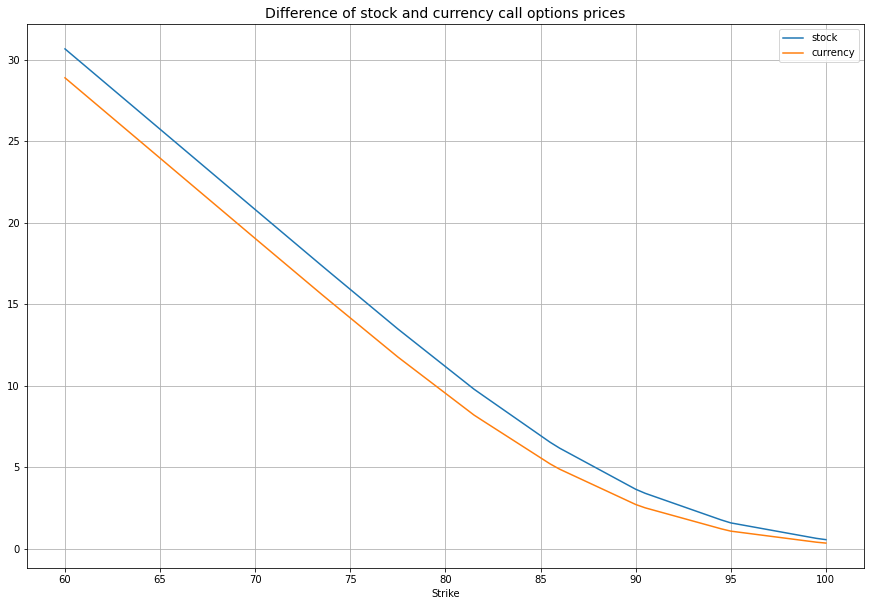

In [12]:
plt.figure(figsize = ((15,10)))
plt.plot(df['strike'], df['european_stock_call'], label = 'stock')
plt.plot(df['strike'], df['european_currency_call'], label = 'currency')
plt.legend()
plt.grid(True)
plt.title('Difference of stock and currency call options prices', fontsize = 14)
plt.xlabel('Strike')
plt.show('Price')

- The reason of different prices if different futures prices resulting in different dividend(foreign rate) numbers

### 2. Black - Sholes model

In [13]:
from scipy.stats import norm

In [14]:
df_black_sholes = pd.DataFrame(data).copy()

df_black_sholes['european_stock_call'] = np.nan
df_black_sholes['european_stock_put'] = np.nan
df_black_sholes['european_currency_call'] = np.nan
df_black_sholes['european_currency_put'] = np.nan

In [15]:
def black_scholes_option(S, K, T, r, q, sigma, option_type='call'):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'call':
        return S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)

In [16]:
S = 90.2  # Stock price
T = 70/365  # Time to maturity (in years)
r = 0.072  # Risk-free rate
sigma = 0.2  # Volatility (assumption!)
q = q # Dividend yield

for i in range(len(df)):
    strike = df_black_sholes['strike'][i]
    european_stock_call = black_scholes_option(S, strike, T, r, q, sigma, option_type ='call')
    european_stock_put = black_scholes_option(S, strike, T, r, q, sigma, option_type ='put')
    
    european_currency_call = black_scholes_option(S, strike, T, r, r_f, sigma, option_type ='call')
    european_currency_put = black_scholes_option(S, strike, T, r, r_f, sigma, option_type ='put')
    
    
    df_black_sholes.loc[i, "european_stock_call"] = european_stock_call
    df_black_sholes.loc[i, "european_stock_put"] = european_stock_put
    
    df_black_sholes.loc[i, "european_currency_call"] = european_currency_call
    df_black_sholes.loc[i, "european_currency_put"] = european_currency_put

#### American options

The Black-Sholes model is applied to European options and can't be applied to American options

#### Result Analysis

In [17]:
df_black_sholes.head(5)

,strike,european_stock_call,european_stock_put,european_currency_call,european_currency_put
0,60.0,30.673517,0.000001,28.898203,0.000004
1,60.5,30.180374,0.000002,28.405062,0.000006
2,65.0,25.742172,0.000090,23.966997,0.000231
3,65.5,25.249070,0.000131,23.473953,0.000331
4,66.0,24.755984,0.000189,22.980948,0.000469


### 3. Monte - carlo model

#### European options

In [18]:
df_monte_carlo = pd.DataFrame(data).copy()

df_monte_carlo['european_stock_call'] = np.nan
df_monte_carlo['european_stock_put'] = np.nan
df_monte_carlo['european_currency_call'] = np.nan
df_monte_carlo['european_currency_put'] = np.nan

In [19]:
def monte_carlo_european_option(S, K, T, r, q, sigma, option_type, simulations=10000):

    
    z = np.random.standard_normal(simulations)
    
    # Simulate end-of-period stock prices (from textbook)
    ST = S * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    
    # Calculate the payoffs
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - ST, 0)
    
    # Discount the average payoff to get the option price
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

In [20]:
# Example
S = 90.2
T = 70/365
r = 0.072
q = q
sigma = 0.2

for i in range(len(df)):
    strike = df_monte_carlo['strike'][i]
    european_stock_call = monte_carlo_european_option(S, strike, T, r, q, sigma, option_type ='call')
    european_stock_put = monte_carlo_european_option(S, strike, T, r, q, sigma, option_type ='put')
    
    european_currency_call = monte_carlo_european_option(S, strike, T, r, r_f, sigma, option_type ='call')
    european_currency_put = monte_carlo_european_option(S, strike, T, r, r_f, sigma, option_type ='put')
    
    
    df_monte_carlo.loc[i, "european_stock_call"] = european_stock_call
    df_monte_carlo.loc[i, "european_stock_put"] = european_stock_put
    
    df_monte_carlo.loc[i, "european_currency_call"] = european_currency_call
    df_monte_carlo.loc[i, "european_currency_put"] = european_currency_put

In [21]:
df_monte_carlo.head(5)

,strike,european_stock_call,european_stock_put,european_currency_call,european_currency_put
0,60.0,30.599252,0.000000,28.743816,0.000000
1,60.5,30.092443,0.000000,28.558082,0.000000
2,65.0,25.679281,0.000019,24.010263,0.000415
3,65.5,25.258973,0.000000,23.473809,0.000601
4,66.0,24.724593,0.000000,22.874192,0.000632


### Pricing analysis

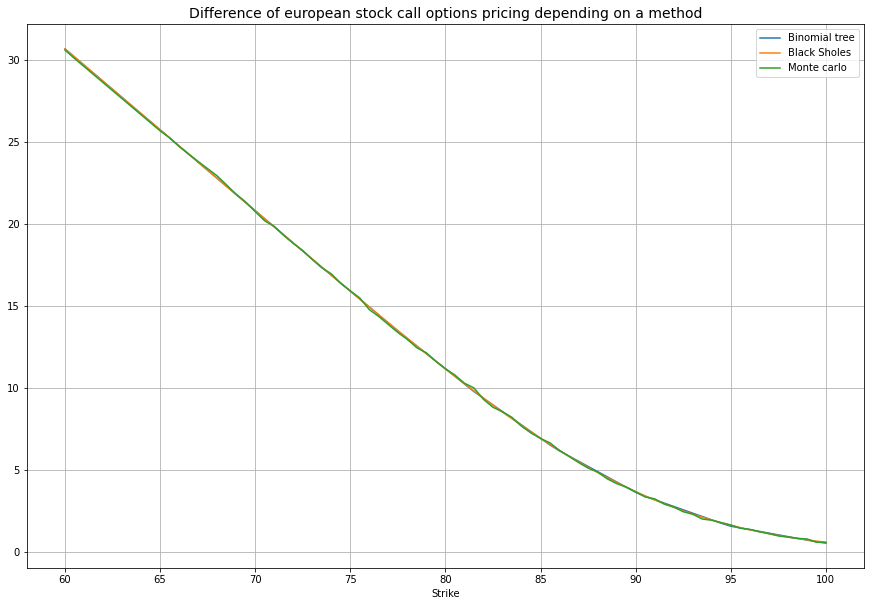

In [22]:
plt.figure(figsize = ((15,10)))
plt.plot(df['strike'], df['european_stock_call'], label = 'Binomial tree')
plt.plot(df['strike'], df_black_sholes['european_stock_call'], label = 'Black Sholes')
plt.plot(df['strike'], df_monte_carlo['european_stock_call'], label = 'Monte carlo')
plt.legend()
plt.grid(True)
plt.title('Difference of european stock call options pricing depending on a method', fontsize = 14)
plt.xlabel('Strike')
plt.show('Price')

As a result, Binomial tree and Black Sholes show almost similar result, while Monte carlo method has some variance

## Greeks (European options)

- In this document we'll calculate Greeks only for European stock options. 
- Greeks for currency options can be calculated by replacing q (dividend yield) with r_f (difference of risk-free rates)

### Implied volatility

In [23]:
df_greeks = pd.DataFrame(data).copy()

In [24]:
S = 90.2  # Stock price
T = 70/365  # Time to maturity (in years)
r = 0.072  # Risk-free rate
sigma = 0.2  # Volatility (assumption!)
q = q # Dividend yield

Implied volatility measures the market's expectation of the future volatility of an underlying asset. It's essential to know market price of an option to calculate the implied volatility. However, I couldn't find out the current price from the excel file --> volatility is assumed 20%

In [25]:
S = 90.2  # Stock price
T = 70/365  # Time to maturity (in years)
r = 0.072  # Risk-free rate
sigma = 0.2  # Volatility (assumption!)
q = q # Dividend yield

### Delta

Delta measures the rate of change of an option's price with respect to changes in the price of its underlying asset allowing to mantain dynamic hedjing

In [26]:
def delta(S, K, T, r, q, sigma, option_type='call'):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    
    if option_type == 'call':
        return math.exp(-q * T) * norm.cdf(d1)
    elif option_type == 'put':
        return math.exp(-q * T) * (norm.cdf(d1) - 1)

In [27]:
for i in range(len(df)):
    strike = df_greeks['strike'][i]
    european_call_delta = delta(S, strike, T, r, q, sigma, option_type='call')
    european_put_delta = delta(S, strike, T, r, q, sigma, option_type='put')
    
    
    df_greeks.loc[i, "european_call_delta"] = european_call_delta
    df_greeks.loc[i, "european_put_delta"] = european_put_delta

In [28]:
df_greeks.head(5)

,strike,european_call_delta,european_put_delta
0,60.0,0.996127,-7.447935e-07
1,60.5,0.996126,-1.191509e-06
2,65.0,0.996079,-4.831293e-05
3,65.5,0.996059,-6.907945e-05
4,66.0,0.996030,-9.779847e-05


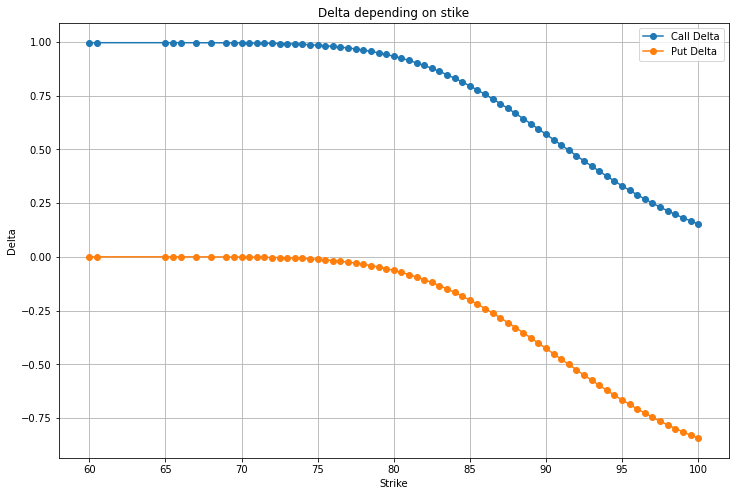

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(df_greeks['strike'], df_greeks['european_call_delta'], label='Call Delta', marker='o')
plt.plot(df_greeks['strike'], df_greeks['european_put_delta'], label='Put Delta', marker='o')
plt.xlabel('Strike')
plt.ylabel('Delta')
plt.title('Delta depending on stike')
plt.legend()
plt.grid(True)
plt.show()

#### Delta depending on Time to expiration (T) and Stock's price (S)
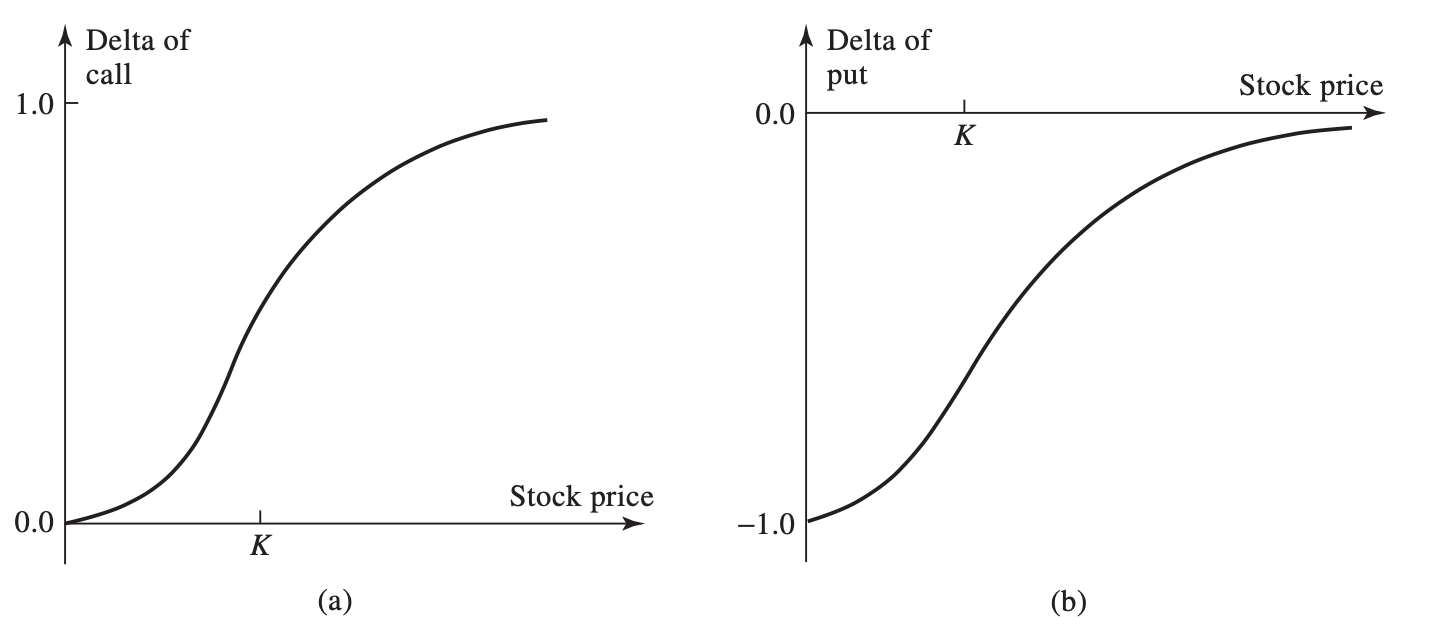
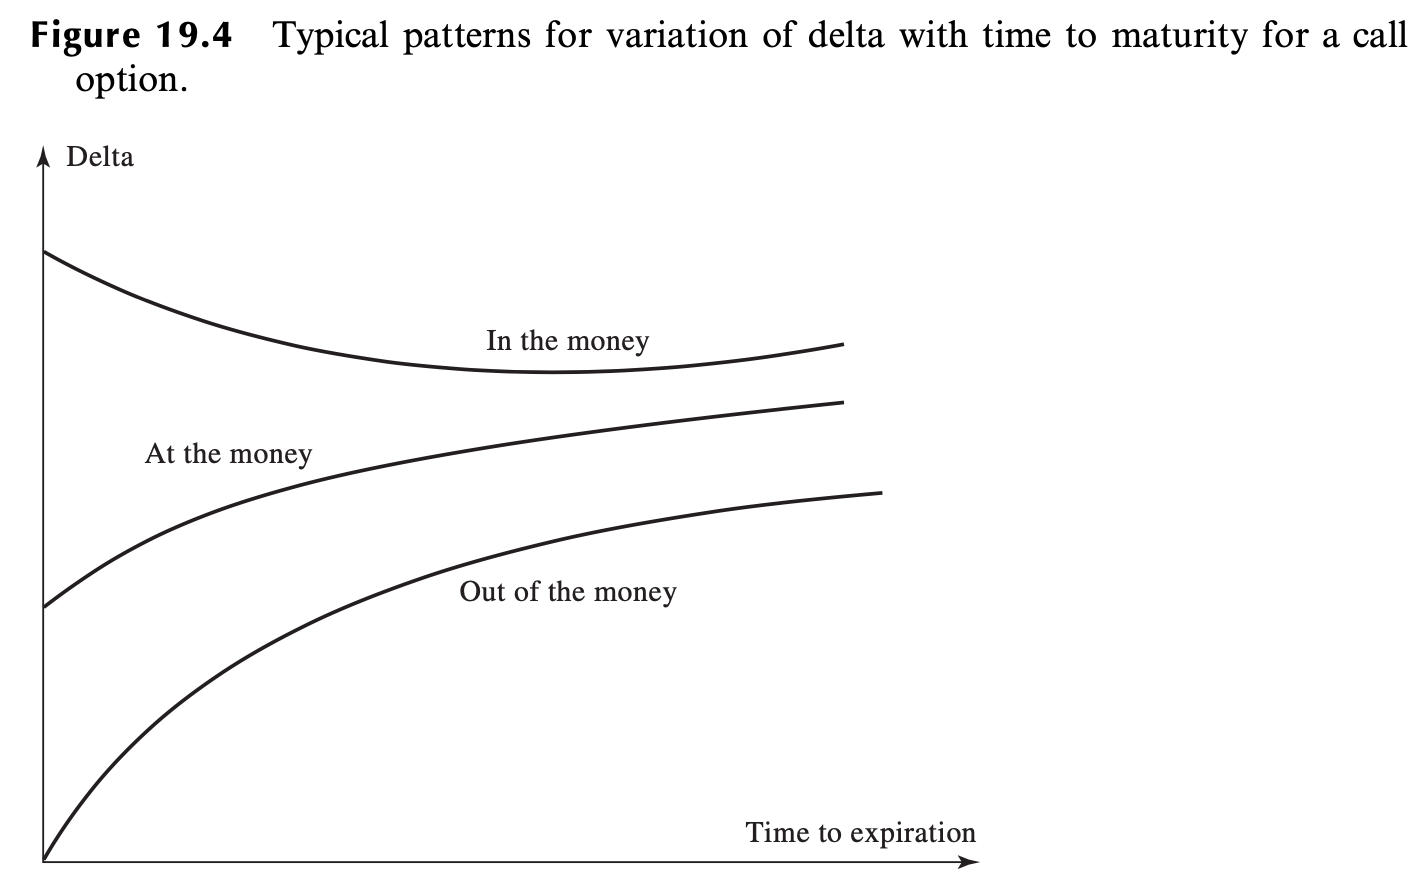

Let's consider call option with $80 strike price and draw how its' delta depends on T and S

In [30]:
K = 80

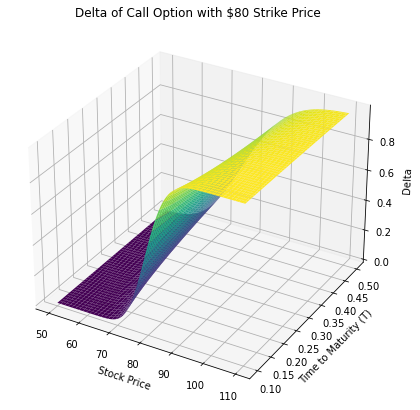

In [31]:
# Variable parameters
S_values = np.linspace(50, 110, 100)  # Stock prices from 50 to 110
T_values = np.linspace(0.1, 0.5, 100)   # Time to maturity from 0.01 to 2 years

S_grid, T_grid = np.meshgrid(S_values, T_values)

# Calculate delta values for each pair of S and T
delta_values = np.array([delta(S, K, T, r, q, sigma) for S, T in zip(np.ravel(S_grid), np.ravel(T_grid))])
delta_grid = delta_values.reshape(S_grid.shape)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, delta_grid, cmap='viridis')

ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Delta')
ax.set_title('Delta of Call Option with $80 Strike Price')
plt.show()

### Theta

Theta represents the rate of change of the option's value with respect to the passage of time

In [32]:
def theta(S, K, T, r, q, sigma, option_type='call'):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == 'call':
        theta_call = (-S * math.exp(-q * T) * norm.pdf(d1) * sigma / (2 * math.sqrt(T))) \
                     - (r * K * math.exp(-r * T) * norm.cdf(d2)) \
                     + (q * S * math.exp(-q * T) * norm.cdf(d1))
        return theta_call
    
    elif option_type == 'put':
        theta_put = (-S * math.exp(-q * T) * norm.pdf(d1) * sigma / (2 * math.sqrt(T))) \
                    + (r * K * math.exp(-r * T) * norm.cdf(-d2)) \
                    - (q * S * math.exp(-q * T) * norm.cdf(-d1))
        return theta_put

In [33]:
for i in range(len(df)):
    strike = df_greeks['strike'][i]
    
    european_call_theta = theta(S, strike, T, r, q, sigma, option_type='call')
    european_put_theta = theta(S, strike, T, r, q, sigma, option_type='put')
    
    df_greeks.loc[i, "european_call_theta"] = european_call_theta
    df_greeks.loc[i, "european_put_theta"] = european_put_theta

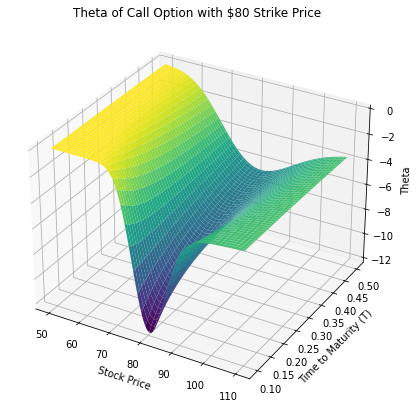

In [34]:
K = 80

# Variable parameters
S_values = np.linspace(50, 110, 100)  # Stock prices from 50 to 110
T_values = np.linspace(0.1, 0.5, 100)   # Time to maturity from 0.01 to 2 years

S_grid, T_grid = np.meshgrid(S_values, T_values)

# Calculate delta values for each pair of S and T
theta_values = np.array([theta(S, K, T, r, q, sigma) for S, T in zip(np.ravel(S_grid), np.ravel(T_grid))])
theta_grid = theta_values.reshape(S_grid.shape)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, theta_grid, cmap='viridis')

ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Theta')
ax.set_title('Theta of Call Option with $80 Strike Price')
plt.show()

### Gamma

Gamma represents the rate of change in the option's Delta with respect to a one-unit change in the underlying asset's price

In [35]:
def gamma(S, K, T, r, q, sigma):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    return (S * math.exp(-q * T) * norm.pdf(d1)) / (sigma * math.sqrt(T))

In [36]:
for i in range(len(df)):
    strike = df_greeks['strike'][i]
    
    european_gamma = gamma(S, strike, T, r, q, sigma)
    
    df_greeks.loc[i, "european_gamma"] = european_gamma

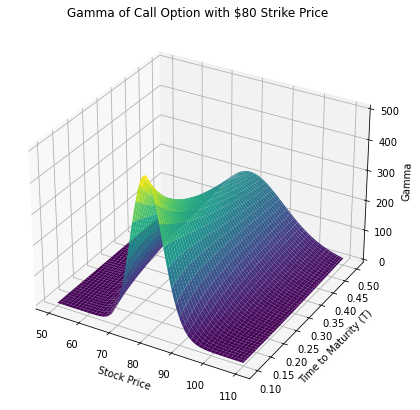

In [37]:
K = 80  # Strike price

# Variable parameters
S_values = np.linspace(50, 110, 100)  # Stock prices from 50 to 110
T_values = np.linspace(0.1, 0.5, 100)   # Time to maturity from 0.01 to 2 years

S_grid, T_grid = np.meshgrid(S_values, T_values)

# Calculate gamma values for each pair of S and T
gamma_values = np.array([gamma(S, K, T, r, q, sigma) for S, T in zip(np.ravel(S_grid), np.ravel(T_grid))])
gamma_grid = gamma_values.reshape(S_grid.shape)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, gamma_grid, cmap='viridis')

ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Gamma')
ax.set_title('Gamma of Call Option with $80 Strike Price')
plt.show()

### Vanna

Vanna measures the rate of change in the Delta of an option with respect to a change in the volatility of the underlying asset. 

In [38]:
def vanna(S, K, T, r, q, sigma, option_type='call'):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == 'call':
        return math.exp(-q * T) * norm.pdf(d1) * d2 / sigma
    elif option_type == 'put':
        return -math.exp(-q * T) * norm.pdf(d1) * d2 / sigma


In [39]:
for i in range(len(df)):
    strike = df_greeks['strike'][i]
    
    european_call_vanna = vanna(S, strike, T, r, q, sigma, option_type='call')
    european_put_vanna = vanna(S, strike, T, r, q, sigma, option_type='put')
    
    df_greeks.loc[i, "european_call_vanna"] = european_call_vanna
    df_greeks.loc[i, "european_put_vanna"] = european_put_vanna

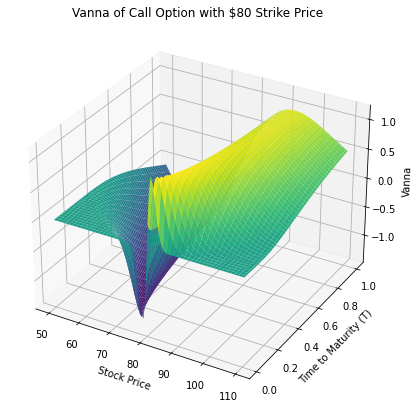

In [40]:
K = 80  # Strike price

# Variable parameters
S_values = np.linspace(50, 110, 100)  # Stock prices from 50 to 110
T_values = np.linspace(0.01, 1, 100)   # Time to maturity from 0.01 to 2 years

S_grid, T_grid = np.meshgrid(S_values, T_values)

# Calculate vanna values for each pair of S and T
vanna_values = np.array([vanna(S, K, T, r, q, sigma) for S, T in zip(np.ravel(S_grid), np.ravel(T_grid))])
vanna_grid = vanna_values.reshape(S_grid.shape)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, vanna_grid, cmap='viridis')

ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Vanna')
ax.set_title('Vanna of Call Option with $80 Strike Price')
plt.show()


### Volga

Volga measures the rate of change in the Vega of an option for a unit change in volatility

In [41]:
def volga(S, K, T, r, q, sigma):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    return S * math.sqrt(T) * math.exp(-q * T) * norm.pdf(d1) * d1 * d2

In [42]:
for i in range(len(df)):
    strike = df_greeks['strike'][i]
    
    european_volga = volga(S, strike, T, r, q, sigma)
    
    df_greeks.loc[i, "european_volga"] = european_volga

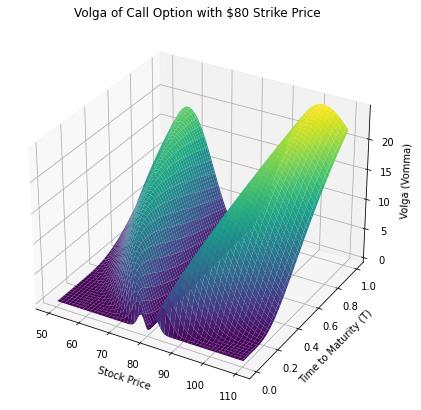

In [43]:
K = 80  # Strike price

# Variable parameters
S_values = np.linspace(50, 110, 100)  # Stock prices from 50 to 110
T_values = np.linspace(0.01, 1, 100)   # Time to maturity from 0.01 to 1 year

S_grid, T_grid = np.meshgrid(S_values, T_values)

# Calculate Volga values for each pair of S and T
volga_values = np.array([volga(S, K, T, r, q, sigma) for S, T in zip(np.ravel(S_grid), np.ravel(T_grid))])
volga_grid = volga_values.reshape(S_grid.shape)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_grid, T_grid, volga_grid, cmap='viridis')

ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Volga (Vomma)')
ax.set_title('Volga of Call Option with $80 Strike Price')
plt.show()

## Result

In [44]:
df_greeks.head(30)

,strike,european_call_delta,european_put_delta,european_call_theta,european_put_theta,european_gamma,european_call_vanna,european_put_vanna,european_volga
0,60.0,0.996127,-7.447935e-07,-2.443097,-0.000073,0.003839,0.000088,-0.000088,0.003347
1,60.5,0.996126,-1.191509e-06,-2.478645,-0.000115,0.006029,0.000136,-0.000136,0.005050
2,65.0,0.996079,-4.831293e-05,-2.801963,-0.003876,0.205411,0.003800,-0.003800,0.117022
3,65.5,0.996059,-6.907945e-05,-2.839017,-0.005424,0.287786,0.005202,-0.005202,0.156591
4,66.0,0.996030,-9.779847e-05,-2.876612,-0.007512,0.399132,0.007046,-0.007046,0.207278
5,67.0,0.995937,-1.904433e-04,-2.954103,-0.013991,0.745371,0.012537,-0.012537,0.351804
6,68.0,0.995770,-3.573468e-04,-3.036202,-0.025077,1.339953,0.021437,-0.021437,0.572913
7,69.0,0.995481,-6.471358e-04,-3.125463,-0.043325,2.322379,0.035275,-0.035275,0.896283
8,69.5,0.995268,-8.597523e-04,-3.173836,-0.056192,3.017175,0.044621,-0.044621,1.104685
9,70.0,0.994995,-1.132769e-03,-3.225402,-0.072252,3.886274,0.055930,-0.055930,1.348494
